In [1]:
%pip install seaborn pandas numpy igraph matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


# Consensus Clustering

Consensus clustering is a method that combines the results of multiple clustering runs to produce a more stable and reliable clustering solution. It is particularly useful when the results of a single clustering algorithm are not robust or consistent across different runs. By aggregating the outputs of various clustering runs, consensus clustering aims to identify clusters that are consistently found across different runs and are therefore more likely to be true representations of the underlying data structur

In [2]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import igraph as ig
import matplotlib.pyplot as plt

In [3]:
%run -i _functions.ipynb

In [4]:
def run_clustering(graph, num_runs, community_detection_method, params=None):
    cooccurrence_matrix = np.zeros((graph.vcount(), graph.vcount()))
    community_detection = build_community_detection_method(graph, community_detection_method, params)
        
    # Run the community detection algorithm for multiple seeds and accumulate the co-occurrence matrix
    for seed in range(num_runs):
        random.seed(seed)
        np.random.seed(seed)
        partition = community_detection(seed)
        # Update cooccurrence matrix
        for community in partition:
            for i in community:
                for j in community:
                    cooccurrence_matrix[i, j] += 1
                    
    cooccurrence_matrix /= num_runs

    return cooccurrence_matrix


def build_cooccurrence_df(cooccurrence_matrix):
    cooccurrence_df = pd.DataFrame(cooccurrence_matrix)
    cooccurrence_df = cooccurrence_df.loc[cooccurrence_df.sum(axis=1).sort_values(ascending=False).index, 
        cooccurrence_df.sum(axis=0).sort_values(ascending=False).index]
    return cooccurrence_df


def plot_heatmap(cooccurrence_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_df, cmap="viridis", cbar=True, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()


def build_graph(cooccurrence_matrix, graph):
    num_nodes = cooccurrence_matrix.shape[0]
    if 'name' in graph.vs.attributes():
        num_vs = graph.vcount()
        node_names = [graph.vs[i]['name'] for i in range(num_vs)]
    else:
        node_names = [f'Item_{i}' for i in range(num_nodes)]

    edges = []
    weights = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes): 
            edges.append((i, j))
            weights.append(cooccurrence_matrix[i, j])
    
    graph = ig.Graph(n=num_nodes, edges=edges, directed=False)
    graph.es['weight'] = weights 
    graph.vs['name'] = node_names

    return graph

def run_consensus_clustering(graph, num_runs, community_detection_method, params=None, plot=True):
    cooccurrence_matrix = run_clustering(graph, num_runs, community_detection_method, params)
    
    if plot:
        cooccurrence_df = build_cooccurrence_df(cooccurrence_matrix)
        plot_heatmap(cooccurrence_df, "Co-occurrence Matrix Heatmap (Louvain Method)")

    g = build_graph(cooccurrence_matrix, graph)
    # le_clusters = g.community_infomap(edge_weights='weight')
    le_clusters = g.community_leading_eigenvector(weights='weight')
    print(f"\nLeading Eigenvector found {len(le_clusters)} communities.")
    for i, cluster in enumerate(le_clusters):
        print(f"  Community {i+1}: {[g.vs[node]['name'] for node in cluster]}")
    # Calculate Modularity
    modularity_le = g.modularity(le_clusters, weights='weight')
    print(f"  Modularity (Leading Eigenvector): {modularity_le:.4f}")
    

In [5]:
karate_club = ig.Graph.Famous("Zachary")

In [6]:
num_runs = 500

## Karate Cub

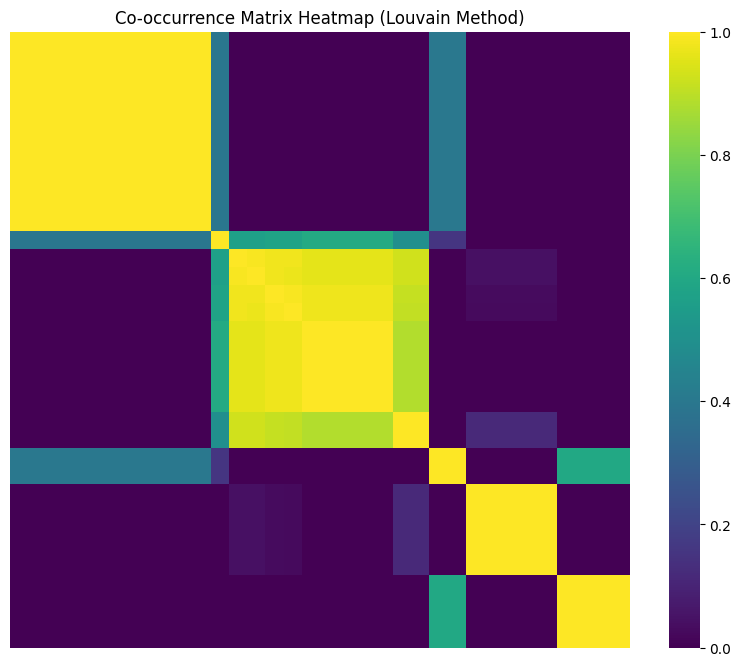

In [7]:
cooccurrence_matrix = run_clustering(karate_club, num_runs, community_detection_method="multilevel")
cooccurrence_df = build_cooccurrence_df(cooccurrence_matrix)
plot_heatmap(cooccurrence_df, "Co-occurrence Matrix Heatmap (Louvain Method)")

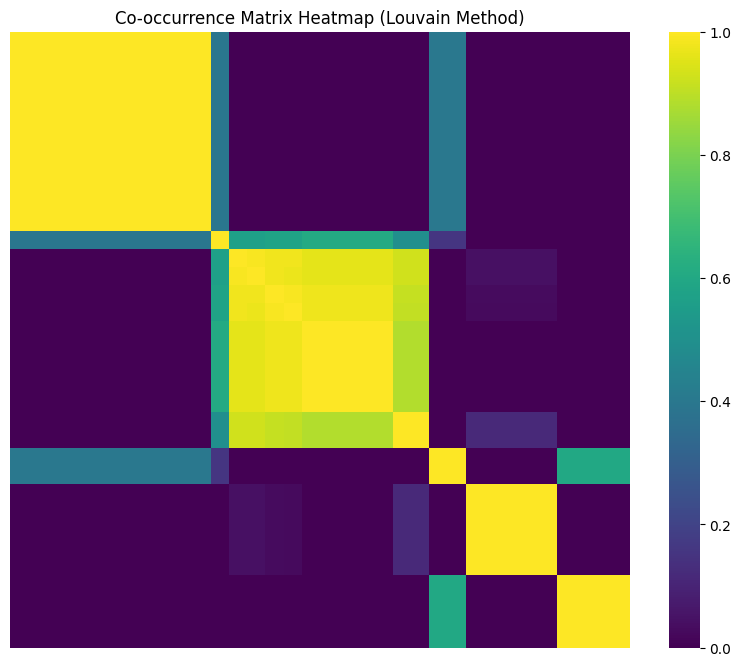


Leading Eigenvector found 4 communities.
  Community 1: ['Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_7', 'Item_9', 'Item_11', 'Item_12', 'Item_13', 'Item_17', 'Item_19', 'Item_21']
  Community 2: ['Item_8', 'Item_14', 'Item_15', 'Item_18', 'Item_20', 'Item_22', 'Item_26', 'Item_29', 'Item_30', 'Item_32', 'Item_33']
  Community 3: ['Item_4', 'Item_5', 'Item_6', 'Item_10', 'Item_16']
  Community 4: ['Item_23', 'Item_24', 'Item_25', 'Item_27', 'Item_28', 'Item_31']
  Modularity (Leading Eigenvector): 0.5452


In [8]:
run_consensus_clustering(karate_club, num_runs, community_detection_method="multilevel", plot=True)

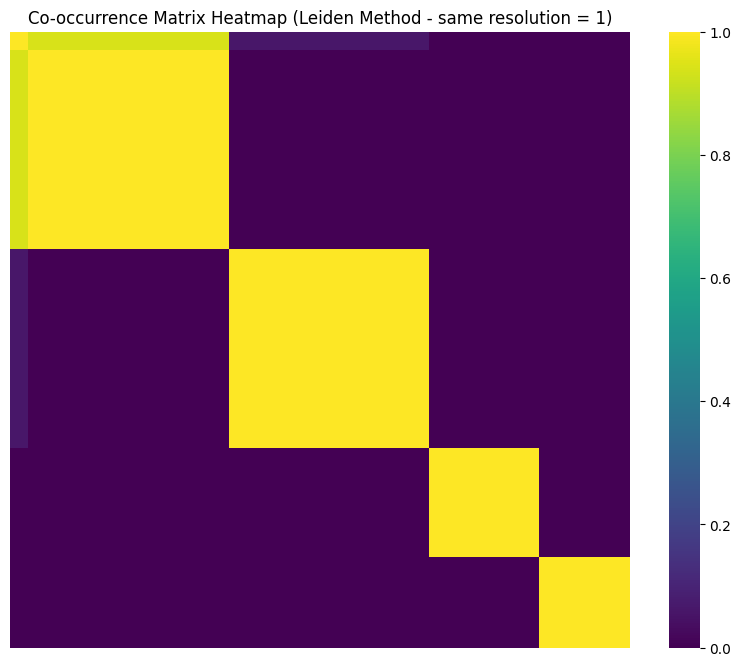

In [9]:
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs)
}

cooccurrence_matrix = run_clustering(karate_club, num_runs, community_detection_method="leiden", params=params)
cooccurrence_df = build_cooccurrence_df(cooccurrence_matrix)
plot_heatmap(cooccurrence_df, "Co-occurrence Matrix Heatmap (Leiden Method - same resolution = 1)")

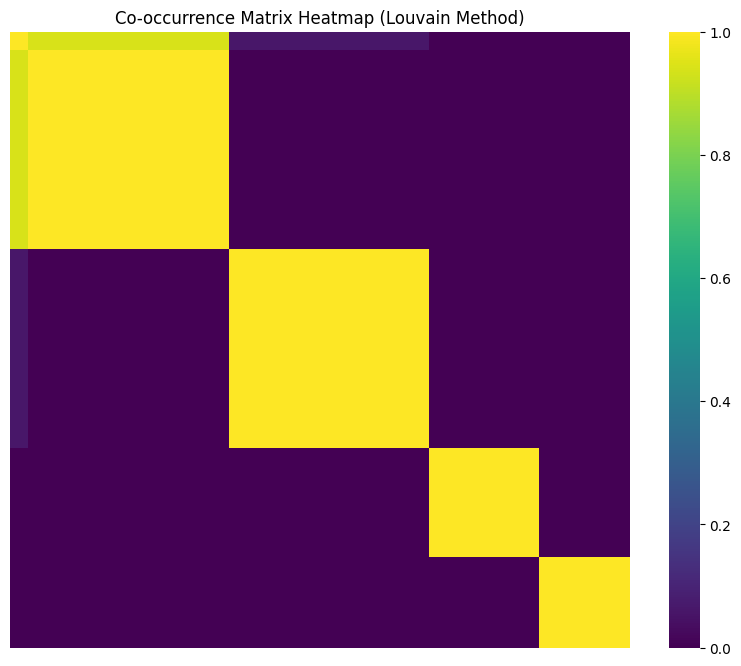


Leading Eigenvector found 4 communities.
  Community 1: ['Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_7', 'Item_11', 'Item_12', 'Item_13', 'Item_17', 'Item_19', 'Item_21']
  Community 2: ['Item_8', 'Item_9', 'Item_14', 'Item_15', 'Item_18', 'Item_20', 'Item_22', 'Item_26', 'Item_29', 'Item_30', 'Item_32', 'Item_33']
  Community 3: ['Item_4', 'Item_5', 'Item_6', 'Item_10', 'Item_16']
  Community 4: ['Item_23', 'Item_24', 'Item_25', 'Item_27', 'Item_28', 'Item_31']
  Modularity (Leading Eigenvector): 0.6343


In [10]:
run_consensus_clustering(karate_club, num_runs, community_detection_method="leiden", params=params, plot=True)

## Game of Thrones

In [11]:
got_network = load_got_network()

Graph created with edge weights using weights=True.


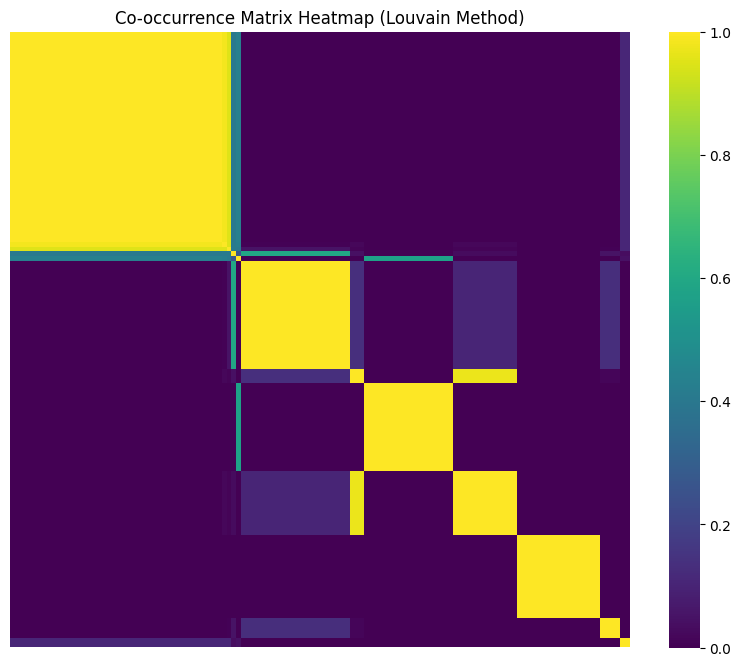


Leading Eigenvector found 5 communities.
  Community 1: ['NED', 'ROBERT', 'LITTLEFINGER', 'VARYS', 'ARYA', 'CERSEI', 'JOFFREY', 'SANSA', 'PYCELLE', 'SEPTA_MORDANE', 'JAIME', 'LORAS', 'RENLY', 'SYRIO_FOREL', 'JORY_CASSEL', 'BARRISTAN', 'YOREN', 'HOUND', 'LANCEL', 'MARILLION', 'JANOS', 'GENDRY', 'HOT_PIE', 'LOMMY_GREENHANDS', 'MERYN_TRANT', 'JON_ARRYN', 'STANNIS', 'MYCAH', 'TOBHO_MOTT', 'MHAEGEN', 'AERYS', 'BAELOR', 'STABLE_BOY', 'HUGH_OF_THE_VALE', 'MOUNTAIN', 'TOMARD', 'RICKARD_STARK', 'ILYN_PAYNE', 'LYANNA', 'RHAEGAR', 'BERIC', 'AEGON', 'HIGH_SEPTON', 'TOMMEN', 'MACE', 'ROOSE_BOLTON', 'STEFFON', 'VARLY']
  Community 2: ['DAENERYS', 'JORAH', 'DROGO', 'VISERYS', 'MIRRI_MAZ_DUUR', 'DOREAH', 'IRRI', 'RAKHARO', 'QOTHO', 'ILLYRIO', 'WINE_MERCHANT', 'RHAEGO', 'MAGO', 'COHOLLO', 'JHIQUI', 'IROGENIA', 'LITTLE_BIRD']
  Community 3: ['CATELYN', 'ROBB', 'THEON', 'BRAN', 'MAESTER_LUWIN', 'ROS', 'WALDER', 'GREATJON_UMBER', 'OSHA', 'RODRIK', 'RICKON', 'HODOR', 'OLD_NAN', 'GARED', 'ROYCE', 'JONOS_BR

In [12]:
params = {
    "weights": "weight"
}
run_consensus_clustering(got_network, num_runs, community_detection_method="multilevel", plot=True, params=params)

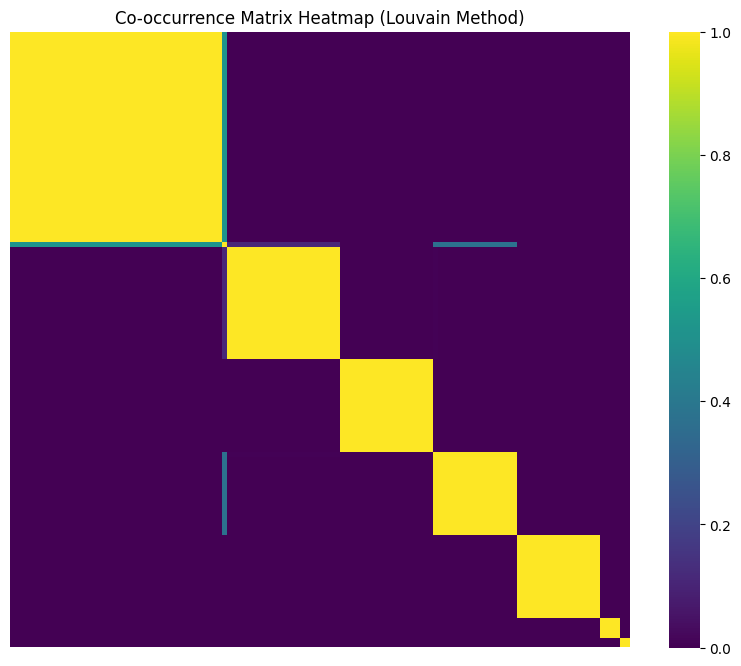


Leading Eigenvector found 7 communities.
  Community 1: ['NED', 'ROBERT', 'LITTLEFINGER', 'VARYS', 'ARYA', 'CERSEI', 'JOFFREY', 'SANSA', 'PYCELLE', 'SEPTA_MORDANE', 'LORAS', 'RENLY', 'SYRIO_FOREL', 'JORY_CASSEL', 'BARRISTAN', 'YOREN', 'HOUND', 'LANCEL', 'MARILLION', 'JANOS', 'GENDRY', 'MERYN_TRANT', 'JON_ARRYN', 'STANNIS', 'MYCAH', 'TOBHO_MOTT', 'MHAEGEN', 'AERYS', 'BAELOR', 'STABLE_BOY', 'HUGH_OF_THE_VALE', 'MOUNTAIN', 'TOMARD', 'RICKARD_STARK', 'ILYN_PAYNE', 'LYANNA', 'RHAEGAR', 'BERIC', 'HIGH_SEPTON', 'TOMMEN', 'MACE', 'ROOSE_BOLTON', 'STEFFON', 'VARLY']
  Community 2: ['DAENERYS', 'JORAH', 'DROGO', 'VISERYS', 'MIRRI_MAZ_DUUR', 'DOREAH', 'IRRI', 'RAKHARO', 'QOTHO', 'ILLYRIO', 'WINE_MERCHANT', 'RHAEGO', 'MAGO', 'COHOLLO', 'JHIQUI', 'IROGENIA', 'LITTLE_BIRD']
  Community 3: ['CATELYN', 'ROBB', 'THEON', 'BRAN', 'MAESTER_LUWIN', 'ROS', 'WALDER', 'GREATJON_UMBER', 'OSHA', 'RODRIK', 'RICKON', 'HODOR', 'OLD_NAN', 'JONOS_BRACKEN', 'RYGER_RIVERS', 'STEVRON_FREY', 'ASSASSIN', 'BALON', 'BRAND

In [13]:
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
    "weights": "weight"
}
run_consensus_clustering(got_network, num_runs, community_detection_method="leiden", params=params, plot=True)